In [1]:
import tweepy
import time
import csv
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive')

In [ ]:
#df = pd.read_parquet('twitter_data.parquet')
#df.drop_duplicates(subset=['tweet_id'])

#old

In [ ]:
df.head(10)

In [ ]:
list(df[df.tweet_id==1406632298183864333].hashtags)

["['IchbinHanna']"]

In [4]:

def clean_data(filename: str):
    def remove_emojis(data):
        emoj = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002500-\U00002BEF"  # chinese char
                          u"\U00002702-\U000027B0"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          u"\U0001f926-\U0001f937"
                          u"\U00010000-\U0010ffff"
                          u"\u2640-\u2642"
                          u"\u2600-\u2B55"
                          u"\u200d"
                          u"\u23cf"
                          u"\u23e9"
                          u"\u231a"
                          u"\ufe0f"  # dingbats
                          u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emoj, '', data)

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')

In [ ]:
def extract_most_frequent_hashtags(dataset):
    dates=list()

    for row,record in enumerate(df.hashtags):
      if record!='[]'and df['timestamp'][row][0:7]>'2021-05' : 
        dates.append(df['timestamp'][row][0:7])
    date=list()
    for dt in dates:
      if dt not in date:
        date.append(dt)




    i=1
    j=6
    for i in range(1,3):
      for j in range(1,13):
        if i==1 and j>5 and j<10 or i==2 and j<10:
          globals()[f'hash202{i}_0{j}']=list()
          globals()[f'hash202{i}_0{j}'].extend([hash for row,hash in enumerate(df['hashtags']) if df['timestamp'][row][0:7]==f'202{i}-0{j}' and hash!='[]'])
            
        elif i==1 and j>5 and j>=10 or i==2 and j>=10:
          globals()[f'hash202{i}_{j}']=list()
          globals()[f'hash202{i}_{j}'].extend([hash for row,hash in enumerate(df['hashtags']) if df['timestamp'][row][0:7]==f'202{i}-{j}' and hash!='[]'])
          
    #preprocessing the hashtags list from specific periods
    i=1
    j=6
    for i in range(1,3):
      for j in range(1,13):
        if i==1 and j>5 and j<10 or i==2 and j<10:
          globals()[f'all_hashtags_202{i}_0{j}']=list()
          for s in globals()[f'hash202{i}_0{j}']:
              bb=s.split(', ')
              a=[re.search(r"[\[\'\"]*(\w*)[\]\']*",i).group(1) for i in bb]
              globals()[f'all_hashtags_202{i}_0{j}'].extend(a)
            
            
        elif i==1 and j>5 and j>=10 or i==2 and j>=10:
          globals()[f'all_hashtags_202{i}_{j}']=list()
          for s in globals()[f'hash202{i}_{j}']:
              bb=s.split(', ')
              a=[re.search(r"[\[\'\"]*(\w*)[\]\']*",i).group(1) for i in bb]
              globals()[f'all_hashtags_202{i}_{j}'].extend(a)


    def hashtag_set_finder():
      hashtag_set=set()
      for dt in date:
          i,j = dt[3],dt[5:]
          lis = globals()[f'all_hashtags_202{i}_{j}']
          for i in lis:
            hashtag_set.add(i)
      return hashtag_set
    hashtags_in_DS=hashtag_set_finder()
    hashtags_in_DS2 = {i.lower() for i in hashtags_in_DS}
    def generate_hashtags(dataset):
      listOfAllHashtags=list()
      for row, hash in enumerate(dataset.hashtags):
        if dataset['timestamp'][row][0:10]>="2021-06-01" and hash!='[]':
          bb=hash.split(', ') 
          
          a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
          listOfAllHashtags.extend(a)
      listOfAllHashtagsL=[i.lower() for i in listOfAllHashtags]
      return listOfAllHashtagsL
    list_of_all_hashtags = generate_hashtags(df)
    dic_of_mfh={i:list_of_all_hashtags.count(i)/len(list_of_all_hashtags) for i in hashtags_in_DS2 if list_of_all_hashtags.count(i)>500}
      #input_hashtags = [i[0] for i in list_of_mfh]
    return dic_of_mfh

In [ ]:
def hashtag_groups():
    representative_hashtags=list()
    model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')
    dic_of_mfh= extract_most_frequent_hashtags(df)
    input_hashtags=list(dic_of_mfh.keys())
    sentence = input_hashtags
    embedding_full = model.encode(sentence)
    clusterd_hashtags=list()
    for hash in input_hashtags:
      embedding = model.encode(hash)
      sublist={hash}
      for j in range(len(input_hashtags)):
        if j<len(input_hashtags)-1:
          if util.pytorch_cos_sim(embedding,model.encode(input_hashtags[j+1])) > 0.5:
              sublist.add(input_hashtags[j+1])
              input_hashtags.remove(input_hashtags[j+1])
      clusterd_hashtags.append(sublist)

      clusterd_hashtags.sort(reverse=True, key= lambda i: len(i))
    print("for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative\n")
    for i in clusterd_hashtags:
      i=list(i)
      group_n=i[0]
      for j in i:
        if dic_of_mfh[j] > dic_of_mfh[group_n]:
          group_n=j
      representative_hashtags.append(group_n)
      print(f"group name  :  {group_n}" )
      print(f'{i}\n') 
    return representative_hashtags

In [ ]:
representative_hashtgas2=hashtag_groups()

for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative

group name  :  ichbinhanna
['ichbinhannaat', 'ichbinhannach', 'ichbinhanna', 'ichbinreyhan', 'ichbinhannah']

group name  :  waspostdocswollen
['daad', 'waspostdocswollen', 'postdocs']

group name  :  hochschulen
['academia', 'hochschule', 'hochschulen']

group name  :  wisskomm
['woisthanna', 'wisskomm', 'ichwarhanna']

group name  :  dauerstellen
['dauerstellenfürdaueraufgaben', 'dauerstellen', 'befristung']

group name  :  hannaimbundestag
['hannastreikt', 'hannaimbundestag', 'hannainzahlen']

group name  :  academictwitter
['academicchatter', 'academictwitter']

group name  :  berlhg
['berlhg', 'hrk']

group name  :  wissenschaft
['forschung', 'wissenschaft']

group name  :  tvstud
['bundestag', 'tvstud']

group name  :  bmbf
['bmbf']

group name  :  27juni
['27juni']

group name  :  twittercampus
['twittercampus']

group name  :  dasgewinnenwir
['dasgewinnen

In [ ]:
representative_hashtgas2

['ichbinhanna',
 'waspostdocswollen',
 'hochschulen',
 'wisskomm',
 'dauerstellen',
 'hannaimbundestag',
 'academictwitter',
 'berlhg',
 'wissenschaft',
 'tvstud',
 'bmbf',
 '27juni',
 'twittercampus',
 'dasgewinnenwir',
 'ugnovelle',
 'karliczek',
 'corona']

In [ ]:
representative_hashtgas=hashtag_groups()

for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative

group name  :  ichbinhanna
['ichbinhannaat', 'ichbinhannach', 'ichbinhanna', 'ichbinreyhan', 'ichbinhannah']

group name  :  waspostdocswollen
['daad', 'waspostdocswollen', 'postdocs']

group name  :  hochschulen
['academia', 'hochschule', 'hochschulen']

group name  :  wisskomm
['woisthanna', 'wisskomm', 'ichwarhanna']

group name  :  dauerstellen
['dauerstellenfürdaueraufgaben', 'dauerstellen', 'befristung']

group name  :  hannaimbundestag
['hannastreikt', 'hannaimbundestag', 'hannainzahlen']

group name  :  academictwitter
['academicchatter', 'academictwitter']

group name  :  berlhg
['berlhg', 'hrk']

group name  :  wissenschaft
['forschung', 'wissenschaft']

group name  :  tvstud
['bundestag', 'tvstud']

group name  :  bmbf
['bmbf']

group name  :  27juni
['27juni']

group name  :  twittercampus
['twittercampus']

group name  :  dasgewinnenwir
['dasgewinnen

In [ ]:
representative_hashtgas

['ichbinhanna',
 'waspostdocswollen',
 'hochschulen',
 'wisskomm',
 'dauerstellen',
 'hannaimbundestag',
 'academictwitter',
 'berlhg',
 'wissenschaft',
 'tvstud',
 'bmbf',
 '27juni',
 'twittercampus',
 'dasgewinnenwir',
 'ugnovelle',
 'karliczek',
 'corona']

In [ ]:
print(representative_hashtgas)

['ichbinhanna', 'waspostdocswollen', 'hochschulen', 'wisskomm', 'dauerstellen', 'hannaimbundestag', 'academictwitter', 'berlhg', 'wissenschaft', 'tvstud', 'bmbf', '27juni', 'twittercampus', 'dasgewinnenwir', 'ugnovelle', 'karliczek', 'corona']


In [ ]:
def tweet_clustering(dataset,tweet_id,rep_hashtags):
  model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')
  hashclusters=set()
  tweet_hashtags=list()
  embedding_full = model.encode(rep_hashtags)
  hashtags=str(list(df[df.tweet_id==tweet_id].hashtags))
  hashtags=hashtags.split(', ')
  a=[re.search(r"[\[\'\"]*(\w*)[\]\']*",i).group(1) for i in hashtags]
  tweet_hashtags.extend(a)
  #print(a)
  if not tweet_hashtags[0]:
    print("no hashtags found for this tweet")
    return 

  for tw_hash in tweet_hashtags:
    embedding = model.encode(tw_hash)
    for rep_hash in rep_hashtags:
        if util.pytorch_cos_sim(embedding,model.encode(rep_hash)) > 0.5:
            hashclusters.add(rep_hash)

  return  hashclusters    

In [ ]:
tweet_clustering(df,1406632298183864333,representative_hashtgas)

{'ichbinhanna'}

In [ ]:
tweet_clustering(df,1406716159064485895,representative_hashtgas)

no hashtags found for this tweet


# new 

In [4]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=0be5604ecc728358763d21d5421901fd1de57a61c6e83804fe07747269b390fa
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [5]:
model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')

In [6]:
def clean_data(filename: str):
    def remove_emojis(data):
        emoj = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002500-\U00002BEF"  # chinese char
                          u"\U00002702-\U000027B0"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          u"\U0001f926-\U0001f937"
                          u"\U00010000-\U0010ffff"
                          u"\u2640-\u2642"
                          u"\u2600-\u2B55"
                          u"\u200d"
                          u"\u23cf"
                          u"\u23e9"
                          u"\u231a"
                          u"\ufe0f"  # dingbats
                          u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emoj, '', data)

    # Removing mentions and hashtags and url
    def remove_mentions_and_tags(text):
        text = re.sub(r'@\S*', '', text)
        text = re.sub(r'http\S+', '', text)
        return re.sub(r'#\S*', '', text)

    read_df = pd.read_parquet(filename)
    read_df = read_df.loc[read_df['tweet_type'] != 'retweet']
    read_df = read_df.drop_duplicates(subset=['tweet_id'], ignore_index=True)
    read_df.text = read_df.text.apply(remove_emojis)
    read_df.text = read_df.text.apply(remove_mentions_and_tags)
    read_df['text'] = read_df['text'].str.replace(
        r'[^\w\s]+', '')  # remove punctuations
    read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number
    

    return read_df












def print_beauty(df, word_topic_df):
    for i in range(6, 10):
        print('Tweet:', df.iloc[i].Tweet)
        print('Hashtags:', df.iloc[i].Hashtags)
        print('Topic_Probability:', df.iloc[i].Topic_Probability)
        print("----------------------------------------------------------------\n")

    for i in range(4):
        print("Topic ", (i+1))
        print("Most Probable Word List: ",
              word_topic_df.iloc[i].most_prob_words)
        print("-------------------------------------------------------\n")







In [7]:
read_df = clean_data("twitter_data.parquet")

<ipython-input-6-9455a7364e49>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  read_df['text'] = read_df['text'].str.replace(
<ipython-input-6-9455a7364e49>:38: FutureWarning: The default value of regex will change from True to False in a future version.
  read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number


In [31]:
def extract_most_frequent_hashtags(df):
    dates = list()

    for row, record in enumerate(df.hashtags):
        if record != '[]' and df['timestamp'][row][0:7] > '2021-05':
            dates.append(df['timestamp'][row][0:7])
    date = list()
    for dt in dates:
        if dt not in date:
            date.append(dt)

    i = 1
    j = 6
    for i in range(1, 3):
        for j in range(1, 13):
            if i == 1 and j > 5 and j < 10 or i == 2 and j < 10:
                globals()[f'hash202{i}_0{j}'] = list()
                globals()[f'hash202{i}_0{j}'].extend([hash for row, hash in enumerate(
                    df['hashtags']) if df['timestamp'][row][0:7] == f'202{i}-0{j}' and hash != '[]'])

            elif i == 1 and j > 5 and j >= 10 or i == 2 and j >= 10:
                globals()[f'hash202{i}_{j}'] = list()
                globals()[f'hash202{i}_{j}'].extend([hash for row, hash in enumerate(
                    df['hashtags']) if df['timestamp'][row][0:7] == f'202{i}-{j}' and hash != '[]'])

    # preprocessing the hashtags list from specific periods
    i = 1
    j = 6
    for i in range(1, 3):
        for j in range(1, 13):
            if i == 1 and j > 5 and j < 10 or i == 2 and j < 10:
                globals()[f'all_hashtags_202{i}_0{j}'] = list()
                for s in globals()[f'hash202{i}_0{j}']:
                    bb = s.split(', ')
                    a = [re.search(r"[\[\'\"]*(\w*)[\]\']*", i).group(1)
                         for i in bb]
                    globals()[f'all_hashtags_202{i}_0{j}'].extend(a)

            elif i == 1 and j > 5 and j >= 10 or i == 2 and j >= 10:
                globals()[f'all_hashtags_202{i}_{j}'] = list()
                for s in globals()[f'hash202{i}_{j}']:
                    bb = s.split(', ')
                    a = [re.search(r"[\[\'\"]*(\w*)[\]\']*", i).group(1)
                         for i in bb]
                    globals()[f'all_hashtags_202{i}_{j}'].extend(a)

    def hashtag_set_finder():
        hashtag_set = set()
        for dt in date:
            i, j = dt[3], dt[5:]
            lis = globals()[f'all_hashtags_202{i}_{j}']
            for i in lis:
                hashtag_set.add(i)
        return hashtag_set
    hashtags_in_DS = hashtag_set_finder()
    hashtags_in_DS2 = {i.lower() for i in hashtags_in_DS}

    def generate_hashtags(dataset):
        listOfAllHashtags = list()
        for row, hash in enumerate(dataset.hashtags):
            if dataset['timestamp'][row][0:10] >= "2021-06-01" and hash != '[]':
                bb = hash.split(', ')

                a = [re.search(r"[\[\']*(\w*)[\]\']*", i).group(1) for i in bb]
                listOfAllHashtags.extend(a)
        listOfAllHashtagsL = [i.lower() for i in listOfAllHashtags]
        return listOfAllHashtagsL
    list_of_all_hashtags = generate_hashtags(df)
    dic_of_mfh = {i: list_of_all_hashtags.count(
        i)/len(list_of_all_hashtags) for i in hashtags_in_DS2 if list_of_all_hashtags.count(i) > 20}
    #input_hashtags = [i[0] for i in list_of_mfh]
    return dic_of_mfh


def hashtag_groups(df):
    representative_hashtags = list()
    
    dic_of_mfh = extract_most_frequent_hashtags(df)
    input_hashtags = list(dic_of_mfh.keys())
    sentence = input_hashtags
    clusterd_hashtags = list()
    for hash in input_hashtags:
        embedding = model.encode(hash)
        sublist = {hash}
        for j in range(len(input_hashtags)):
            if j < len(input_hashtags)-1:
                if util.pytorch_cos_sim(embedding, model.encode(input_hashtags[j+1])) > 0.5:
                    sublist.add(input_hashtags[j+1])
                    input_hashtags.remove(input_hashtags[j+1])
        clusterd_hashtags.append(sublist)

        clusterd_hashtags.sort(reverse=True, key=lambda i: len(i))
    print("for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative\n")
    for i in clusterd_hashtags:
        i = list(i)
        group_n = i[0]
        for j in i:
            if dic_of_mfh[j] > dic_of_mfh[group_n]:
                group_n = j
        representative_hashtags.append(group_n)
        print(f"group name  :  {group_n}")
        print(f'{i}\n')
    return representative_hashtags,clusterd_hashtags


def tweet_clustering(df, tweet_id, rep_hashtags, model):
  hashclusters = set()
  tweet_hashtags = list()
  hashtags = str(list(df[df.tweet_id == tweet_id].hashtags))
  hashtags = hashtags.split(', ')
  a = [re.search(r"[\[\'\"]*(\w*)[\]\']*", i).group(1) for i in hashtags]
  tweet_hashtags.extend(a)
  #print(a)
  if not tweet_hashtags[0]:
    print("no hashtags found for this tweet")
    return

  for tw_hash in tweet_hashtags:
    embedding = model.encode(tw_hash)
    highestsim=0
    hash=""
    for rep_hash in rep_hashtags:
        sim=util.pytorch_cos_sim(embedding, model.encode(rep_hash))
        if  sim> 0.5 and sim>highestsim:
          highestsim=sim
          hash=rep_hash
            
    hashclusters.add(hash)


        
  if not hashclusters:
    print("hashtags in this tweet are very infrequent and disimilar to the founded groups") 
  return list(hashclusters)

In [32]:
representative_hashtgas,clustered_hashtags=hashtag_groups(read_df)

for each cluster a group name has been extracted based on the most frequent hashtag of that group or a Group Representative

group name  :  berlhg
['ugnovelle', 'dfg', 'hrk', 'scholz', 'berlhg', 'guttenberg', 'bafög', 'bmbf', 'bafög50', 'karliczek', 'abo', 'lehre', 'bipocs', 'phdlife', 'baerbock', 'göttingen']

group name  :  hochschulen
['entfristethanna', 'hochschulpolitik', 'tvstudjetzt', 'streiksemester', 'nachwuchs', 'hochschulen', 'hochschulendemokratisieren', 'ausstieghochschule', 'hochschule', 'trump']

group name  :  dauerstellen
['zeitverträge', 'dauerstellenfürdaueraufgaben', 'befristungen', 'befristung', 'überstunden', 'entfristung', 'daueraufgaben', 'zwangsteilzeit', 'dauerstellen', 'arbeitszeiterfassung']

group name  :  ichwarhanna
['hannainzahlen', 'ichwarhanna', 'hannawählt', 'hanna', 'woisthanna', 'hannaorganisiertsich', 'wirsindhanna', 'hannagehtwählen']

group name  :  unigöttingen
['unigöttingen', 'hitzefrei', 'jlugiessen', 'freibad', 'wissenschaftsfreiheit', 'mitt

In [11]:
len(representative_hashtgas)

52

In [30]:
representative_hashtgas

['berlhg',
 'hochschulen',
 'dauerstellen',
 'ichwarhanna',
 'unigöttingen',
 'ichbinhanna',
 'academia',
 'tvstud',
 'deutschlanddeineschulden',
 'wissenschaft',
 'arbeiterkind',
 'hannaimbundestag',
 'unionize',
 'weilwirwissenschaftlieben',
 'anschlussverwendung',
 'btw21',
 'waspostdocswollen',
 'arbeitsbedingungen',
 'forschung',
 'mlunterfinanziert',
 'streik',
 'wisskomm',
 'mehrhabeck',
 'openaccess',
 'zukunftsvertrag',
 'koalitionsvertrag',
 'wohlstand',
 'ampel',
 'sachsenanhalt',
 'wissenschaftszeitvertragsgesetz',
 'wisszeitvg',
 'bundestag',
 'twittercampus',
 '95vswisszeitvg',
 'unverzichtbar',
 'mint',
 'digitalisierung',
 'innovation',
 'personalentwicklung',
 'mentalhealth',
 'hrkadvent',
 'frististfrust',
 'pandemie',
 'corona',
 'stopthecuts',
 'acertaindegreeofflexibility',
 'thesis_ev',
 'einkaufszentrum',
 'speakupostbelgien',
 'keineausnahme',
 'bipoc',
 'dasgewinnenwir']

In [12]:
# saving the clustered_hashtags
import pickle
with open('clusterd_hashtags_52.txt','wb') as file:
  pickle.dump(representative_hashtgas, file) 
#with open('clusterd_hashtags.txt','rb') as f:
#  clusterd_hashtags=pickle.load(f)


In [14]:
dates=list()

for row,record in enumerate(read_df.hashtags):
  if record!='[]'and read_df['timestamp'][row][0:7]>'2021-05' : 
    dates.append(read_df['timestamp'][row][0:7])

date=list()
for dt in dates:
  if dt not in date:
    date.append(dt)
date.sort()
date_each3= [dt for row, dt in enumerate(date) if row%3==0]

In [18]:
i=1
j=6
for i in range(1,3):
  for j in range(1,13):
    if i==1 and j>5 and j<10 or i==2 and j<10:
      globals()[f'hash202{i}_0{j}']=list()
      globals()[f'hash202{i}_0{j}'].extend([hash for row,hash in enumerate(read_df['hashtags']) if read_df['timestamp'][row][0:7]==f'202{i}-0{j}' and hash!='[]'])
        
    elif i==1 and j>5 and j>=10 or i==2 and j>=10:
      globals()[f'hash202{i}_{j}']=list()
      globals()[f'hash202{i}_{j}'].extend([hash for row,hash in enumerate(read_df['hashtags']) if read_df['timestamp'][row][0:7]==f'202{i}-{j}' and hash!='[]'])


#preprocessing the hashtags list from specific periods
i=1
j=6
for i in range(1,3):
  for j in range(1,13):
    if i==1 and j>5 and j<10 or i==2 and j<10:
      globals()[f'all_hashtags_202{i}_0{j}']=list()
      for s in globals()[f'hash202{i}_0{j}']:
          bb=s.split(', ')
          a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
          globals()[f'all_hashtags_202{i}_0{j}'].extend(a)
        
        
    elif i==1 and j>5 and j>=10 or i==2 and j>=10:
      globals()[f'all_hashtags_202{i}_{j}']=list()
      for s in globals()[f'hash202{i}_{j}']:
          bb=s.split(', ')
          a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
          globals()[f'all_hashtags_202{i}_{j}'].extend(a)

In [19]:
def hashtag_counter(hash_ls,txt):
  lis=list()
  for hashtag in hash_ls:
    lis.append(hashtag.lower())
  return lis.count(txt.lower())
def hashtag_num_list(hashtag):
  hashtag_num=list()
  for dt in date_each3:
      i,j = dt[3],dt[5:]
      lis = globals()[f'all_hashtags_202{i}_{j}']
      hashtag_num.append(hashtag_counter(lis,hashtag))
  return hashtag_num
def group_hash_numlist(group):
  return np.sum([hashtag_num_list(i) for i in group],axis=0)    

In [21]:
def mf_g_hash(cluster):
  group_dic=dict()
  for r,group in enumerate(cluster):
    hash_num=np.sum([hashtag_num_list(i) for i in group])
    #group=list(group)
    group_dic[r]=hash_num
  group_dic=sorted(group_dic.items(),key= lambda k:k[1],reverse=True)
  return group_dic

In [40]:
most_frequent_groups=mf_g_hash(clustered_hashtags)
new_hash_set=[i[0] for r,i in enumerate(most_frequent_groups) if r<10]

In [34]:
most_frequent_groups

[(5, 19398),
 (30, 2368),
 (11, 968),
 (0, 849),
 (2, 515),
 (3, 455),
 (33, 356),
 (45, 353),
 (9, 347),
 (6, 331),
 (1, 313),
 (4, 246),
 (41, 231),
 (8, 155),
 (7, 150),
 (31, 147),
 (10, 145),
 (26, 103),
 (12, 93),
 (16, 90),
 (21, 89),
 (13, 84),
 (18, 84),
 (22, 78),
 (15, 75),
 (14, 66),
 (32, 65),
 (47, 63),
 (39, 52),
 (29, 41),
 (46, 40),
 (17, 35),
 (43, 35),
 (23, 34),
 (27, 32),
 (35, 28),
 (19, 26),
 (40, 26),
 (49, 26),
 (28, 24),
 (44, 24),
 (37, 20),
 (24, 19),
 (50, 19),
 (20, 12),
 (36, 12),
 (42, 11),
 (25, 10),
 (38, 8),
 (48, 7),
 (34, 6),
 (51, 6)]

In [25]:
def generate_hashtags(dataset):
  listOfAllHashtags=list()
  for row, hash in enumerate(dataset.hashtags):
    if dataset['timestamp'][row][0:10]>="2021-06-01" and hash!='[]':
      bb=hash.split(', ') 
      
      a=[re.search(r"[\[\']*(\w*)[\]\']*",i).group(1) for i in bb]
      listOfAllHashtags.extend(a)
  listOfAllHashtagsL=[i.lower() for i in listOfAllHashtags]
  return listOfAllHashtagsL
list_of_all_hashtags = generate_hashtags(read_df)

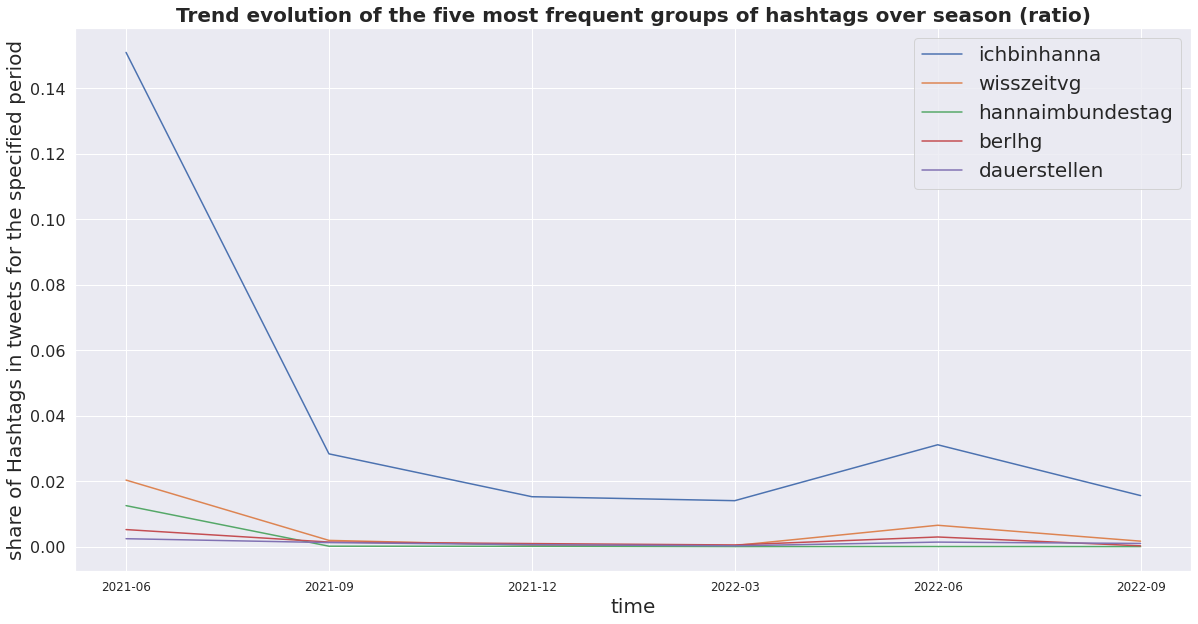

In [48]:
%matplotlib inline
sns.set(style="darkgrid")
fig = plt.figure(figsize = (20, 10))
for i in new_hash_set[0:5]:
  plt.plot(date_each3,np.array(group_hash_numlist(clustered_hashtags[i]))/np.size(list_of_all_hashtags))#/summ

plt.legend([f'{representative_hashtgas[i]}' for i in new_hash_set[0:5]], fontsize=20) 
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)

plt.xlabel("time",fontsize = 20)
plt.ylabel("share of Hashtags in tweets for the specified period",fontsize = 20)
plt.title("Trend evolution of the five most frequent groups of hashtags over season (ratio)",fontsize = 20,fontweight='bold')
plt.show()


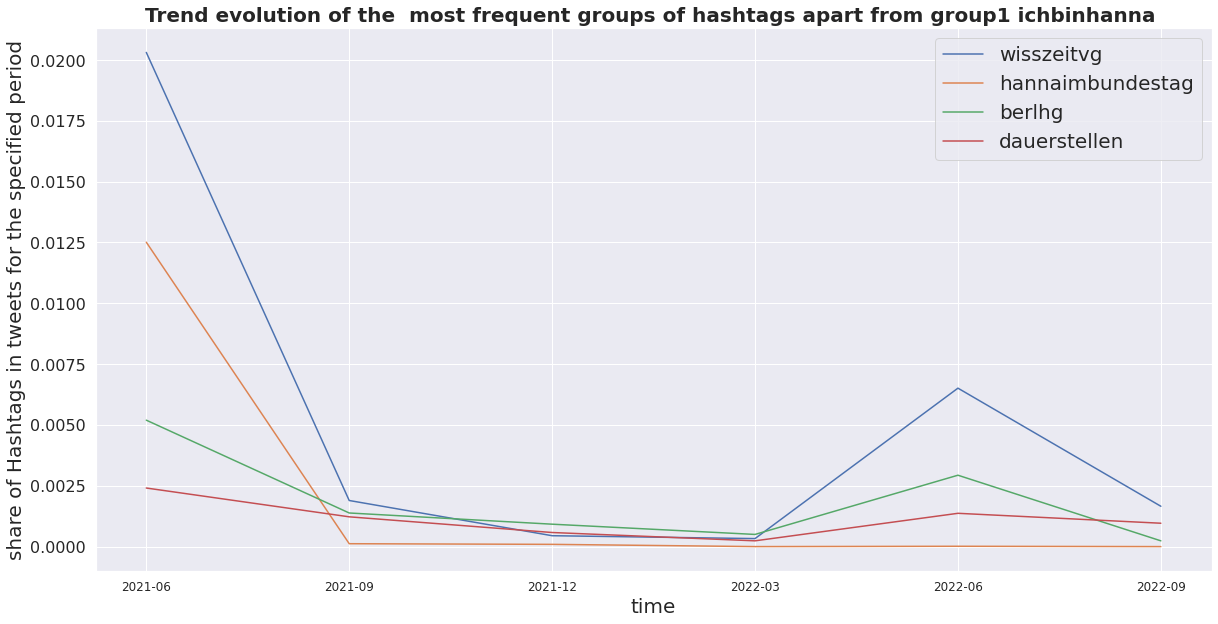

In [47]:
%matplotlib inline
sns.set(style="darkgrid")
fig = plt.figure(figsize = (20, 10))
for i in new_hash_set[1:5]:
  plt.plot(date_each3,np.array(group_hash_numlist(clustered_hashtags[i]))/np.size(list_of_all_hashtags))#/summ

plt.legend([f'{representative_hashtgas[i]}' for i in new_hash_set[1:5]], fontsize=20) 
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)

plt.xlabel("time",fontsize = 20)
plt.ylabel("share of Hashtags in tweets for the specified period",fontsize = 20)
plt.title("Trend evolution of the  most frequent groups of hashtags apart from group1 ichbinhanna ",fontsize = 20,fontweight='bold')
plt.show()


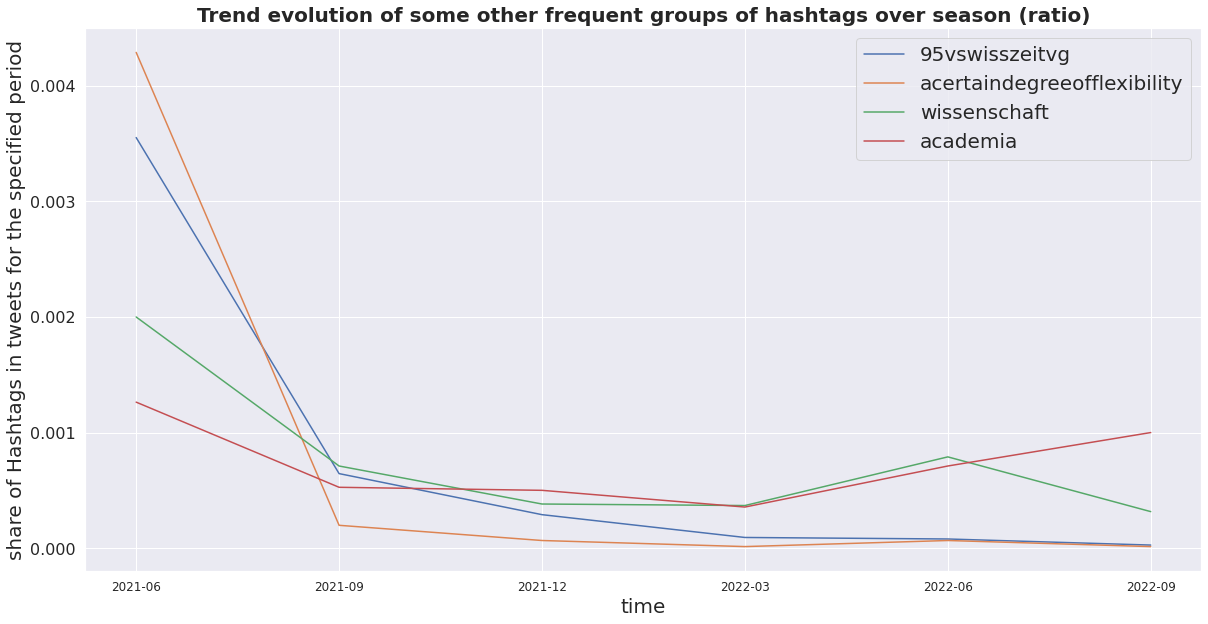

In [50]:
%matplotlib inline
sns.set(style="darkgrid")
fig = plt.figure(figsize = (20, 10))
for i in new_hash_set[6:11]:
  plt.plot(date_each3,np.array(group_hash_numlist(clustered_hashtags[i]))/np.size(list_of_all_hashtags))#/summ

plt.legend([f'{representative_hashtgas[i]}' for i in new_hash_set[6:11]], fontsize=20) 
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)

plt.xlabel("time",fontsize = 20)
plt.ylabel("share of Hashtags in tweets for the specified period",fontsize = 20)
plt.title("Trend evolution of some other frequent groups of hashtags over season (ratio)",fontsize = 20,fontweight='bold')
plt.show()
